In [1]:
import numpy as np
import xgboost as xgb
from wideboost.wrappers import wxgb

import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

ds_train, ds_info = tfds.load(
    'titanic',
    split=['train'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

for i in ds_train[0].batch(60000):
    a = i

In [2]:
## Keep only numeric columns. Randomly split the dataset into training and test

X = []
for s in a[0].keys():
    if a[0][s].dtype != tf.string:
        X.append(a[0][s].numpy().reshape([-1,1]))

X = np.concatenate(X,axis=1)

idx = np.arange(X.shape[0])
np.random.seed(1)
train_idx = np.random.choice(idx, round(0.7*X.shape[0]), replace=False)
test_idx = np.setdiff1d(idx,train_idx)

xtrain = X[train_idx,:]
ytrain = a[1].numpy()[train_idx]

xtest = X[test_idx,:]
ytest = a[1].numpy()[test_idx]

dtrain = xgb.DMatrix(xtrain,label=ytrain)
dtest = xgb.DMatrix(xtest,label=ytest)

In [13]:
%%time
param = {'max_depth':2, 'eta':0.1, 'objective':'binary:logistic','eval_metric':['error']}
num_round = 500
watchlist = [(dtrain,'train'),(dtest,'test')]
xgb_results = dict()
bst = xgb.train(param, dtrain, num_round,watchlist,evals_result=xgb_results, verbose_eval=10)

[0]	train-error:0.20524	test-error:0.24427
[10]	train-error:0.20524	test-error:0.24427
[20]	train-error:0.19651	test-error:0.22901
[30]	train-error:0.18450	test-error:0.22392
[40]	train-error:0.17904	test-error:0.23155
[50]	train-error:0.17795	test-error:0.22646
[60]	train-error:0.17358	test-error:0.22137
[70]	train-error:0.17467	test-error:0.21628
[80]	train-error:0.16812	test-error:0.21120
[90]	train-error:0.16812	test-error:0.21374
[100]	train-error:0.16703	test-error:0.21374
[110]	train-error:0.16485	test-error:0.21628
[120]	train-error:0.16157	test-error:0.21374
[130]	train-error:0.16266	test-error:0.22137
[140]	train-error:0.16157	test-error:0.22137
[150]	train-error:0.15830	test-error:0.22137
[160]	train-error:0.15611	test-error:0.21628
[170]	train-error:0.15393	test-error:0.21374
[180]	train-error:0.15284	test-error:0.21374
[190]	train-error:0.15175	test-error:0.21120
[200]	train-error:0.15066	test-error:0.21120
[210]	train-error:0.14956	test-error:0.20865
[220]	train-error:0.1

In [16]:
%%time
# 'btype' = 'I', 'beta_eta' = 0 and 'extra_dims' = 0 is equivalent to boosting
param['extra_dims'] = 0
param['btype'] = 'I'   
param['beta_eta'] = 0
param['output_dim'] = 1


wxgb_results = dict()
watchlist = [((xtrain, ytrain.reshape([ytrain.shape[0], 1])),'train'),((xtest, ytest.reshape([ytest.shape[0], 1])),'test')]
wbst = wxgb.fit(
    xtrain, ytrain.reshape([ytrain.shape[0], 1]),
    param, num_round, watchlist,evals_result=wxgb_results,
    verbose_eval=10
)

[0]	train-error:0.20524	test-error:0.24427
[10]	train-error:0.20524	test-error:0.24427
[20]	train-error:0.19651	test-error:0.22901
[30]	train-error:0.18450	test-error:0.22392
[40]	train-error:0.17904	test-error:0.23155
[50]	train-error:0.17795	test-error:0.22646
[60]	train-error:0.17358	test-error:0.22137
[70]	train-error:0.17467	test-error:0.21629
[80]	train-error:0.16812	test-error:0.21120
[90]	train-error:0.16812	test-error:0.21374
[100]	train-error:0.16703	test-error:0.21374
[110]	train-error:0.16485	test-error:0.21629
[120]	train-error:0.16157	test-error:0.21374
[130]	train-error:0.16266	test-error:0.22137
[140]	train-error:0.16157	test-error:0.22137
[150]	train-error:0.15830	test-error:0.22137
[160]	train-error:0.15611	test-error:0.21629
[170]	train-error:0.15393	test-error:0.21374
[180]	train-error:0.15284	test-error:0.21374
[190]	train-error:0.15175	test-error:0.21120
[200]	train-error:0.15066	test-error:0.21120
[210]	train-error:0.14956	test-error:0.20865
[220]	train-error:0.1

In [23]:
%%time
# Adding more dimensions fits more trees per round but also decreases loss with fewer boost rounds
param['extra_dims'] = 10
param['beta_eta'] = 0.0000001  # beta_eta can be really unstable, sometimes best to leave at 0
wxgb10_results = dict()
wbst = wxgb.fit(
    xtrain, ytrain.reshape([ytrain.shape[0], 1]),
    param, num_round, watchlist, evals_result=wxgb10_results,
    verbose_eval=10
)

[0]	train-error:0.20524	test-error:0.24427
[10]	train-error:0.17140	test-error:0.21629
[20]	train-error:0.15721	test-error:0.21120
[30]	train-error:0.13210	test-error:0.22392
[40]	train-error:0.12882	test-error:0.23664
[50]	train-error:0.12664	test-error:0.22901
[60]	train-error:0.11900	test-error:0.23155
[70]	train-error:0.12009	test-error:0.22646
[80]	train-error:0.11572	test-error:0.22646
[90]	train-error:0.11026	test-error:0.23155
[100]	train-error:0.10153	test-error:0.22392
[110]	train-error:0.10044	test-error:0.22137
[120]	train-error:0.09498	test-error:0.22137
[130]	train-error:0.09716	test-error:0.21883
[140]	train-error:0.09280	test-error:0.22137
[150]	train-error:0.09061	test-error:0.21120
[160]	train-error:0.08406	test-error:0.21374
[170]	train-error:0.08515	test-error:0.21374
[180]	train-error:0.08406	test-error:0.21120
[190]	train-error:0.08188	test-error:0.21120
[200]	train-error:0.08079	test-error:0.20611
[210]	train-error:0.08079	test-error:0.20865
[220]	train-error:0.0

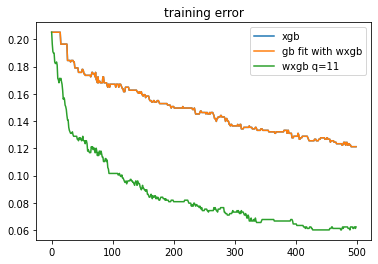

In [24]:
plt.plot(xgb_results['train']['error'], label='xgb')
plt.plot(wxgb_results['train']['error'], label='gb fit with wxgb')
plt.plot(wxgb10_results['train']['error'], label='wxgb q=11')
plt.legend()
plt.title('training error')
plt.show()